In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from scipy.stats import boxcox
%matplotlib inline

In [2]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [3]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (4, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)

        plt.tight_layout()
    return

In [4]:
def moving_average(series, n):
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    return series.rolling(n).mean()

In [5]:
def weighted_moving_average(series, n, weights):
    if not isinstance(weights, np.ndarray):
        weights = np.array(weights)
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    wma = series.rolling(n).apply(lambda s: (s * weights).sum() / weights.sum(), raw=True)
    return wma

In [6]:
def exponential_moving_average(series, alpha):
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return pd.Series(result)

In [7]:
def double_ema(series, alpha, beta):
    result = [series[0]]
    level, trend = series[0], series[1] - series[0]
    for n in range(1, len(series)):
        value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return pd.Series(result)

# **Стационарный ряд**

In [8]:
female_births = pd.read_csv("daily-total-female-births-in-cal.csv")

In [9]:
series1 = female_births['Count']

Results of Dickey-Fuller Test:
Test Statistic                  -4.808291
p-value                          0.000052
#Lags Used                       6.000000
Number of Observations Used    358.000000
Critical Value (1%)             -3.448749
Critical Value (5%)             -2.869647
Critical Value (10%)            -2.571089
dtype: float64


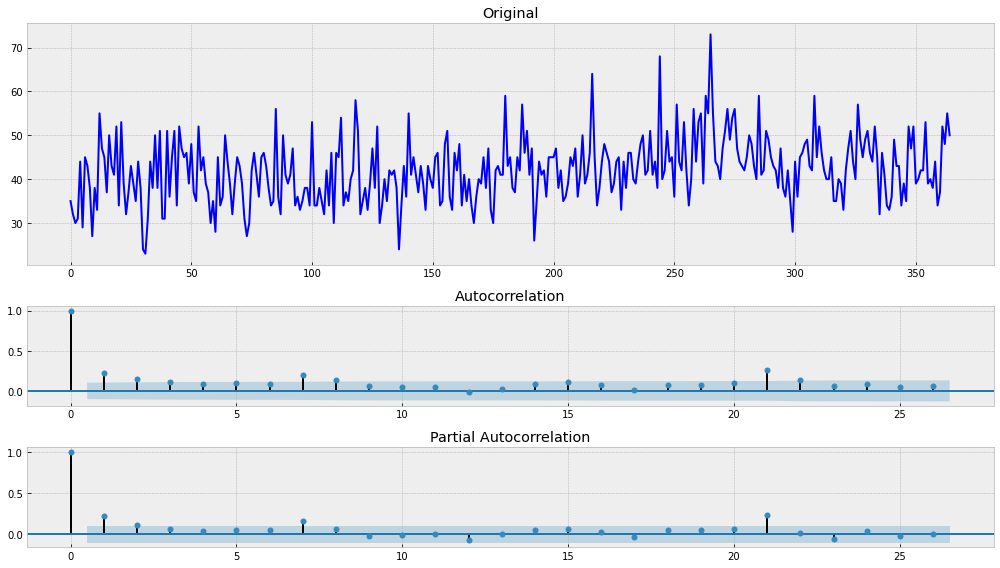

In [10]:
tsplot(series1)

Скользящее среднее

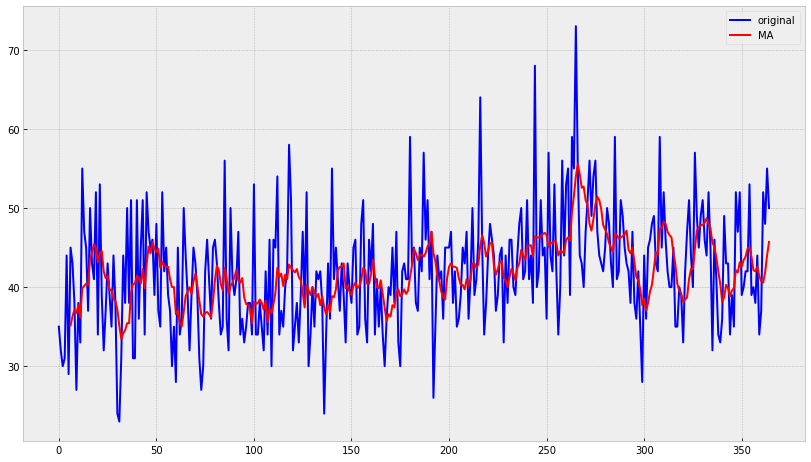

In [17]:
ma = moving_average(series1, 7)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series1, color='blue',label='original')
    plt.plot(ma, color='red', linewidth='2', label='MA')
    plt.legend()

Взвешенное скользящее среднее с весами из последовательности Фибоначи

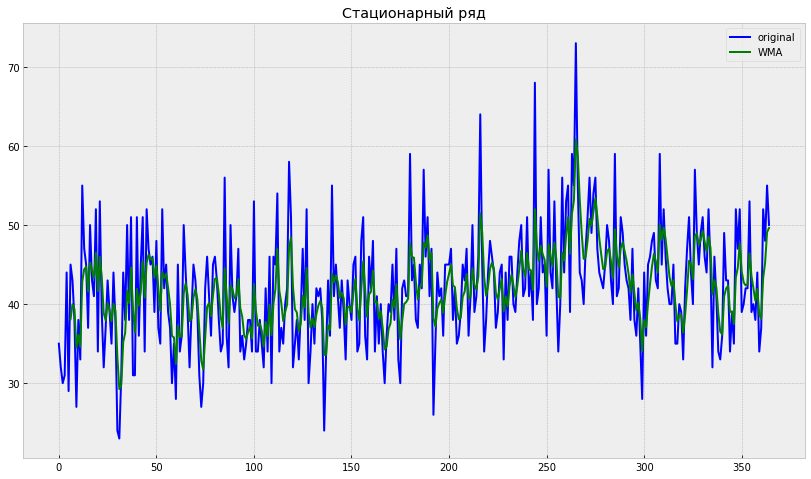

In [18]:
wma = weighted_moving_average(series1, 7, [1,1,2,3,5,8,13])
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series1, color='blue',label='original')
    plt.plot(wma, color='green', linewidth='2', label='WMA')
    plt.title("Стационарный ряд")
    plt.legend()

Взвешенное скользящее среднее приблизило лучше чем просто скользящее среднее. Особенно заметно улучшение для самых низших значений. 

Экспоненциальное сглаживание

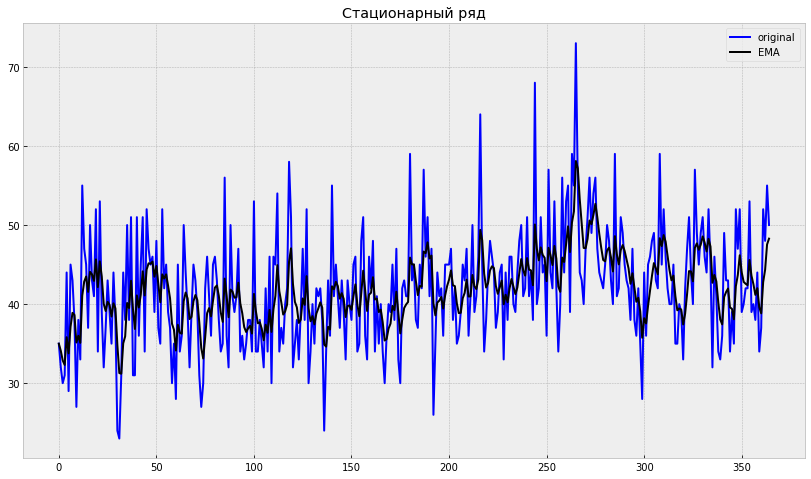

In [21]:
ema = exponential_moving_average(series1, 0.3)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series1, color='blue',label='original')
    plt.plot(ema, color='black', linewidth='2', label='EMA')
    plt.title("Стационарный ряд")
    plt.legend()

Приблизило ряд очень похоже со взвешенным скользящим средним, сложно сказать какая модель из них лучше. 

Двойное экспоненциальное сглаживание

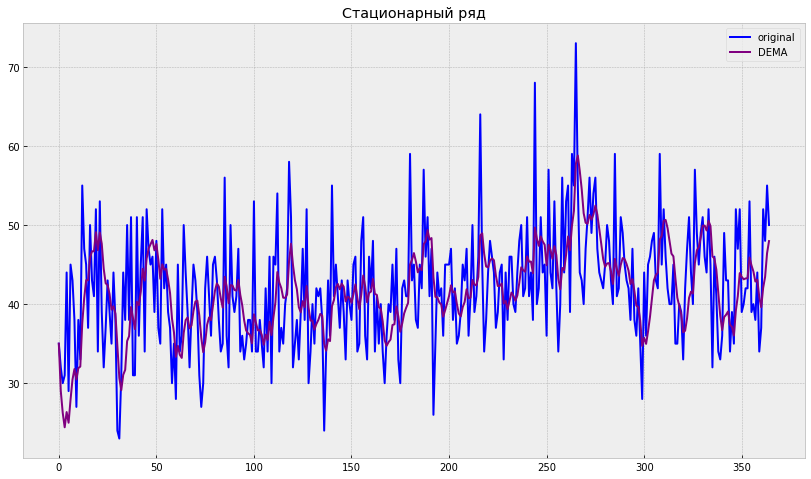

In [22]:
dema = double_ema(series1, 0.2, 0.2)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series1, color='blue',label='original')
    plt.plot(dema, color='purple', linewidth='2', label='DEMA')
    plt.title("Стационарный ряд")
    plt.legend()

Приблизило ряд хуже, чем предыдущие две модели. 

Получается, что лучше всего приблизили ряд модели взвешенного скользящего среднего и экспоненциального сглаживания.

# **Нестационарный ряд**

In [12]:
robberies_in_boston = pd.read_csv("monthly-boston-armed-robberies-j.csv")

In [13]:
series2 = robberies_in_boston['Count']

Results of Dickey-Fuller Test:
Test Statistic                   1.001102
p-value                          0.994278
#Lags Used                      11.000000
Number of Observations Used    106.000000
Critical Value (1%)             -3.493602
Critical Value (5%)             -2.889217
Critical Value (10%)            -2.581533
dtype: float64


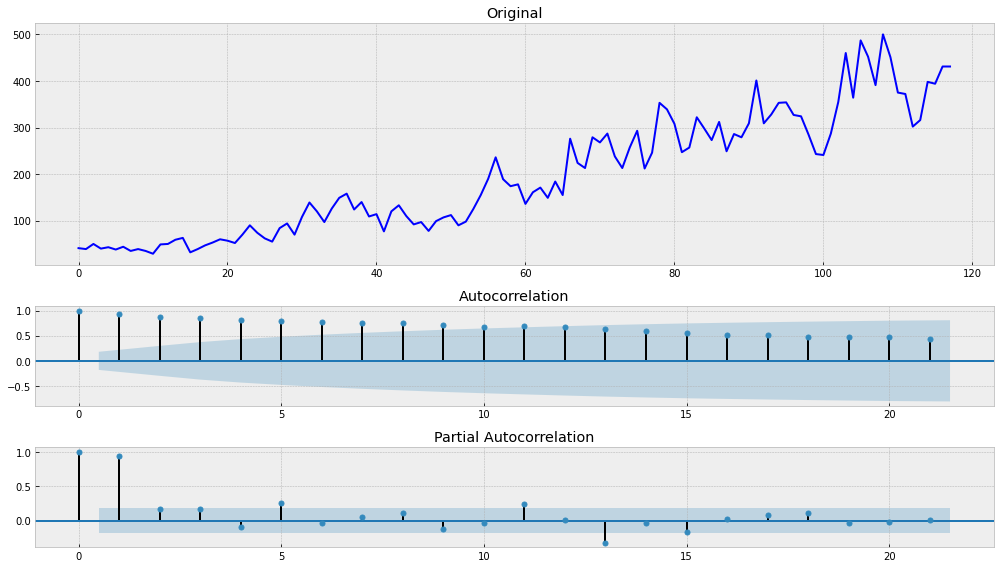

In [14]:
tsplot(series2)

Скользящее среднее

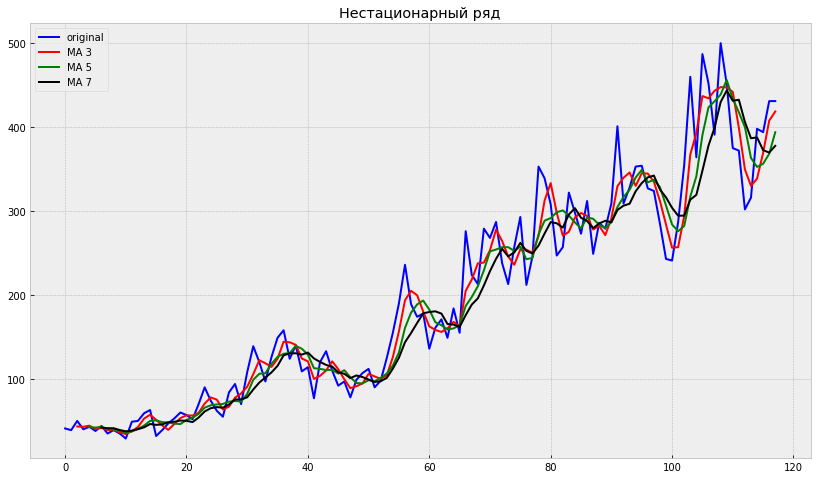

In [34]:
ma_3 = moving_average(series2, 3)
ma_5 = moving_average(series2, 5)
ma_7 = moving_average(series2, 7)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series2, color='blue',label='original')
    plt.plot(ma_3, color='red', linewidth='2', label='MA 3')
    plt.plot(ma_5, color='green', linewidth='2', label='MA')
    plt.plot(ma_7, color='black', linewidth='2', label='MA')
    plt.title("Нестационарный ряд")
    plt.legend()

Взвешенное скользящее среднее с весами из последовательности Фибоначи

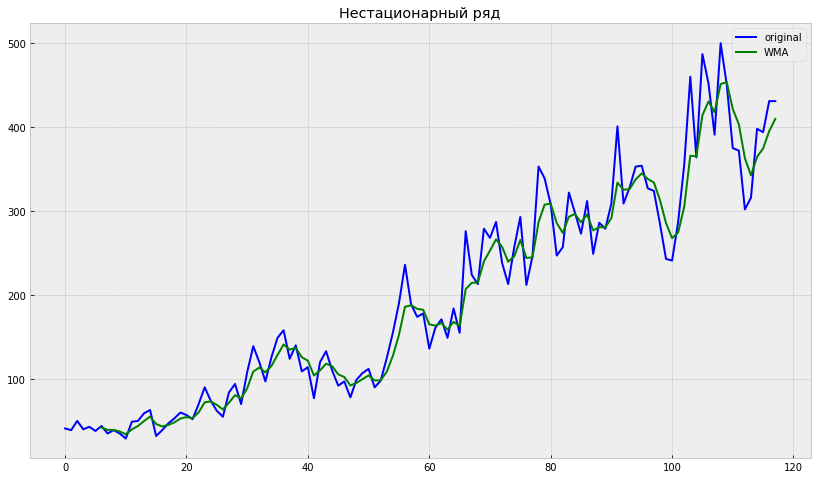

In [24]:
wma = weighted_moving_average(series2, 7, [1,1,2,3,5,8,13])
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series2, color='blue',label='original')
    plt.plot(wma, color='green', linewidth='2', label='WMA')
    plt.title("Нестационарный ряд")
    plt.legend()

Экспоненциальное сглаживание

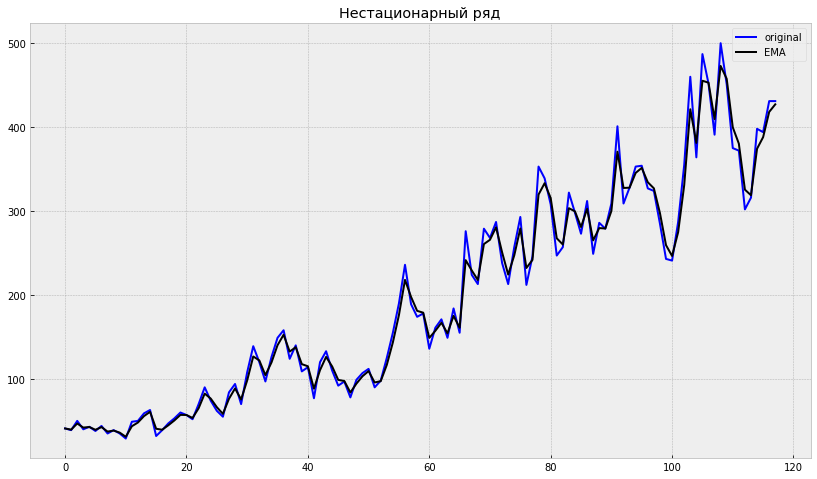

In [36]:
ema = exponential_moving_average(series2, 0.7)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series2, color='blue',label='original')
    plt.plot(ema, color='black', linewidth='2', label='EMA')
    plt.title("Нестационарный ряд")
    plt.legend()

Двойное экспоненциальное сглаживание

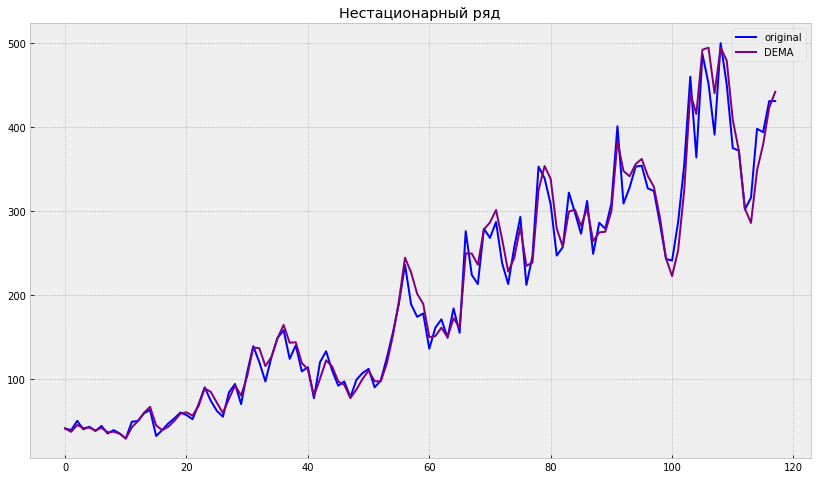

In [40]:
dema = double_ema(series2, 0.6, 0.3)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series2, color='blue',label='original')
    plt.plot(dema, color='purple', linewidth='2', label='DEMA')
    plt.title("Нестационарный ряд")
    plt.legend()

Для нестационарного ряда с наличием тренда экспоненциальные модели дают приближение лучше чем модели скользящего среднего.